<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/main/notebooks/BiGAN_DCGAN_DownstreamTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Implementation Remote Sensing

## Import necessary packages

In [1]:
!pip install lightning-bolts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import standard python libraries
import os
import datetime as time
from datetime import datetime
import numpy as np
import pickle as pkl
import glob
from pathlib import Path
from math import floor
import random
from itertools import chain
from typing import List, Any

# import data reader, logging and transforms
from torchvision import transforms
from torchvision import datasets
import torchvision
from tqdm import tqdm

# import the PyTorch deep learning library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split, Subset, SubsetRandomSampler
import torchvision.utils as vutils
from torch.autograd import Variable
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pl_bolts.callbacks import LatentDimInterpolator, TensorboardGenerativeModelImageSampler
from sklearn.metrics import classification_report

# import matplotlib and enabling notebook inline plotting:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/pl_bolts/callbacks/data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
/usr/local/lib/python3.7/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.7/dist-packages/pl_bolts/models/self_supervised

Mount Google Drive Directories for data access

In [3]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# create Colab Notebooks directory
notebook_directory = Path('/content/drive/MyDrive/Projects/DeepLearning')
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

# create data sub-directory inside the Colab Notebooks directory
data_directory = Path('/content/drive/MyDrive/Projects/DeepLearning/data')
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create models sub-directory inside the Colab Notebooks directory
models_directory = Path('/content/drive/MyDrive/Projects/DeepLearning/models')
if not os.path.exists(models_directory): os.makedirs(models_directory)

# checkpoint directory
chkpt_directory = Path('/content/drive/MyDrive/Projects/DeepLearning/checkpoints')
if not os.path.exists(chkpt_directory): os.makedirs(chkpt_directory)

## Helper Functions

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [6]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
if device == "cuda":
  torch.cuda.manual_seed(SEED)

## Dataset Loading

In [7]:
IMAGE_SIZE = 64
transformer_train = transforms.Compose([
                               transforms.ToTensor(),
                               #transforms.Resize(IMAGE_SIZE),
                               #transforms.CenterCrop(IMAGE_SIZE),
                               #transforms.Normalize([87.81586935763889, 96.97416420717593, 103.98142336697049], [51.67849701591506, 34.908630837585186, 29.465280593587384]),
                           ])

transformer_test = transforms.Compose([
                               transforms.ToTensor(),
                               #transforms.Resize(IMAGE_SIZE),
                               #transforms.CenterCrop(IMAGE_SIZE),
                               #transforms.Normalize([87.81586935763889, 96.97416420717593, 103.98142336697049], [51.67849701591506, 34.908630837585186, 29.465280593587384]),
                           ])

In [8]:
torchvision_eurosat_dir = data_directory.joinpath("eurosat")
data = datasets.EuroSAT(root = torchvision_eurosat_dir, transform = transformer_train, download = True)

In [9]:
# create indices
dataset_size = len(data)
indices = list(range(dataset_size))
test_split_ratio = 0.2
split = int(np.floor(test_split_ratio * dataset_size))

# Shuffle & split
np.random.seed(SEED)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# create indices for dataloaders
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)


In [10]:
BATCH_SIZE = 700

train_dataloader = DataLoader(
    dataset = data,
    batch_size = BATCH_SIZE,
    sampler = train_sampler,
)

test_dataloader = DataLoader(
    dataset = data,
    batch_size = BATCH_SIZE,
    sampler = test_sampler,
)

In [11]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [12]:
class Generator(nn.Module):
  def __init__(self, latent_dim: int, feature_maps: int, image_channels: int) -> None:
    super().__init__()

    self.gen = nn.Sequential(
        self._make_gen_block(latent_dim, feature_maps * 8, kernel_size = 4, stride = 1, padding = 0),
        self._make_gen_block(feature_maps * 8, feature_maps * 4),
        self._make_gen_block(feature_maps * 4, feature_maps * 2),
        self._make_gen_block(feature_maps * 2, feature_maps),
        self._make_gen_block(feature_maps, image_channels, last_block=True),
    )

  @staticmethod
  def _make_gen_block(
      in_channels: int,
      out_channels: int,
      kernel_size: int = 4,
      stride: int = 2,
      padding: int = 1,
      bias: bool = False,
      last_block: bool = False,
  ) -> nn.Sequential:
    if not last_block:
      gen_block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(True),
      )
    else:
      gen_block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
          nn.Tanh(),
      )
    
    return gen_block

  def forward(self, noise: Tensor) -> Tensor:
    return self.gen(noise)

In [13]:
class Discriminator(nn.Module):
  def __init__(self, latent_dim: int, feature_maps: int, image_channels: int) -> None:
    super().__init__()

    self.disc_x = nn.Sequential(
        self._make_disc_block(image_channels, feature_maps, batch_norm=False),
        self._make_disc_block(feature_maps, feature_maps * 2),
        self._make_disc_block(feature_maps * 2, feature_maps * 4),
        self._make_disc_block(feature_maps * 4, feature_maps * 8),
        self._make_disc_block(feature_maps * 8, feature_maps * 8, kernel_size = 4, stride = 1, padding = 0, last_block = True),
    )

    self.disc_z = nn.Sequential(
        nn.Conv2d(latent_dim, feature_maps * 8, kernel_size = 1, stride = 1, bias=False),
        nn.LeakyReLU(negative_slope=0.1, inplace=True), 
        nn.Dropout2d(0.2),
        nn.Conv2d(feature_maps * 8, feature_maps * 8, kernel_size = 1, stride = 1, bias=False),
        nn.LeakyReLU(negative_slope=0.1, inplace=True), 
        nn.Dropout2d(0.2),
    )

    self.disc_joint = nn.Sequential(
        nn.Conv2d(feature_maps * 16, feature_maps * 16, kernel_size = 1, stride = 1, bias=False),
        nn.LeakyReLU(negative_slope=0.1, inplace=True), 
        nn.Dropout(0.2),
        nn.Conv2d(feature_maps * 16, feature_maps * 16, kernel_size = 1, stride = 1, bias=False),
        nn.LeakyReLU(negative_slope=0.1, inplace=True), 
        nn.Dropout2d(0.2),
        nn.Conv2d(feature_maps * 16, 1, kernel_size = 1, stride = 1, bias=False)
    )

  @staticmethod
  def _make_disc_block(
      in_channels: int,
      out_channels: int, 
      kernel_size: int = 4,
      stride: int = 2,
      padding: int = 1,
      bias: bool = False,
      batch_norm: bool = True,
      last_block: bool = False,
  ) -> nn.Sequential:
    if not last_block:
      disc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
          nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
          nn.LeakyReLU(0.2, inplace=True),
      )
    else:
      disc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
      )
    
    return disc_block
    
  def forward(self, x: Tensor, z: Tensor) -> Tensor:
    x = self.disc_x(x)
    z = self.disc_z(z)
    joint = torch.cat((x,z), dim=1)
    out = self.disc_joint(joint)
    return torch.sigmoid(out)

In [14]:
class Encoder(nn.Module):
  def __init__(self, latent_dim: int, feature_maps: int, image_channels: int) -> None:
    super().__init__()

    self.enc = nn.Sequential(
        self._make_enc_block(image_channels, feature_maps),
        self._make_enc_block(feature_maps, feature_maps * 2),
        self._make_enc_block(feature_maps * 2, feature_maps * 4),
        self._make_enc_block(feature_maps * 4, feature_maps * 8),
        self._make_enc_block(feature_maps * 8, latent_dim, kernel_size = 4, stride = 1, padding = 0, last_block=True),
    )

  @staticmethod
  def _make_enc_block(
      in_channels: int,
      out_channels: int,
      kernel_size: int = 4,
      stride: int = 2,
      padding: int = 1,
      bias: bool = False,
      last_block: bool = False,
  ) -> nn.Sequential:
    if not last_block:
      enc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(True),
      )
    else:
      enc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
          nn.Tanh(),
      )
    
    return enc_block
    
  def forward(self, x: Tensor) -> Tensor:
    return self.enc(x)

In [15]:
class EncoderBlock(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 5)  # in: 3x64x64 out: 60x60x24
        self.pool = nn.MaxPool2d(2, 2)  # out: 30x30x24
        self.conv2 = nn.Conv2d(24, 72, 5)  # out: 26x26x72

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        return x


class FullyConnectedBlock(nn.Module):

    def __init__(self, input_dim: int):

        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)  # 72 * 13 * 13
        self.fc2 = nn.Linear(512, 124)
        self.fc3 = nn.Linear(124, 10)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DownstreamNet(nn.Module):
    def __init__(self, input_dim: int, encoder = None) -> None:
        super().__init__()
        self.encoder = encoder if encoder else EncoderBlock()
        self.fc = FullyConnectedBlock(input_dim = input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x


## BiGAN

In [16]:
from typing import Any

In [17]:
class BIGAN(LightningModule):

    def __init__(
        self,
        beta1: float = 0.5,
        feature_maps_gen: int = 64,
        feature_maps_disc: int = 64,
        feature_maps_enc: int = 64,
        image_channels: int = 3,
        latent_dim: int = 100,
        learning_rate: float = 0.0002,
        **kwargs: Any,
    ) -> None:

        super().__init__()
        self.beta1 = beta1
        self.feature_maps_gen = feature_maps_gen
        self.feature_maps_disc = feature_maps_disc
        self.feature_maps_enc = feature_maps_enc
        self.image_channels = image_channels
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate

        self.generator = self._get_generator()
        self.discriminator = self._get_discriminator()
        self.encoder = self._get_encoder()

        self.criterion = nn.BCELoss()

    def _get_generator(self) -> nn.Module:
        generator = Generator(self.latent_dim, self.feature_maps_gen, self.image_channels)
        generator.apply(self._weights_init)
        return generator

    def _get_discriminator(self) -> nn.Module:
        discriminator = Discriminator(self.latent_dim, self.feature_maps_disc, self.image_channels)
        discriminator.apply(self._weights_init)
        return discriminator

    def _get_encoder(self) -> nn.Module:
        encoder = Encoder(self.latent_dim, self.feature_maps_enc, self.image_channels)
        encoder.apply(self._weights_init)
        return encoder

    @staticmethod
    def _weights_init(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif classname.find("BatchNorm") != -1:
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def configure_optimizers(self):
        lr = self.learning_rate
        betas = (self.beta1, 0.999)
        opt_disc = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        opt_gen_enc = torch.optim.Adam(chain(self.generator.parameters(), self.encoder.parameters()), lr=lr, betas=betas)
        return [opt_disc, opt_gen_enc], []

    def forward(self, noise: Tensor, x: Tensor):
        """Generates an image given input noise.
        Example::
            noise = torch.rand(batch_size, latent_dim)
            gan = GAN.load_from_checkpoint(PATH)
            img = gan(noise)
        """
        z_fake = Variable(torch.randn((batch_size, self.latent_dim, 1, 1)), requires_grad=False).to(self.device)
        x_fake = self.generator(z_fake)

        x_true = x.float()
        z_true = self.encoder(x_true)

        return x_true, z_true, x_fake, z_fake, 

    def training_step(self, batch, batch_idx, optimizer_idx):
        x, _ = batch

        z_fake = Variable(torch.randn((batch_size, self.latent_dim, 1, 1)), requires_grad=False).to(self.device)
        x_fake = self.generator(z_fake)

        x_true = x.float()
        z_true = self.encoder(x_true)

        # Train discriminator
        result = None
        if optimizer_idx == 0:
            result = self._disc_step(x_true, z_true, x_fake, z_fake)

        # Train generator
        if optimizer_idx == 1:
            result = self._gen_enc_step(x_true, z_true, x_fake, z_fake)

        return result

    def _disc_step(self, x_true: Tensor, z_true: Tensor, x_fake: Tensor, z_fake: Tensor) -> Tensor:
        disc_loss = self._get_disc_loss(x_true, z_true, x_fake, z_fake)
        self.log("loss/disc", disc_loss, on_epoch=True)
        return disc_loss

    def _gen_enc_step(self, x_true: Tensor, z_true: Tensor, x_fake: Tensor, z_fake: Tensor) -> Tensor:
        gen_enc_loss = self._get_gen_enc_loss(x_true, z_true, x_fake, z_fake)
        self.log("loss/gen_enc", gen_enc_loss, on_epoch=True)
        return gen_enc_loss

    def _get_disc_loss(self, x_true: Tensor, z_true: Tensor, x_fake: Tensor, z_fake: Tensor) -> Tensor:
        # Train with real
        out_true = self.discriminator(x_true, z_true)
        y_true = torch.ones_like(out_true)
        real_loss = self.criterion(out_true, y_true)

        # Train with fake
        out_fake = self.discriminator(x_fake, z_fake)
        y_fake = torch.zeros_like(out_fake)
        fake_loss = self.criterion(out_fake, y_fake)

        disc_loss = real_loss + fake_loss

        return disc_loss

    def _get_gen_enc_loss(self, x_true: Tensor, z_true: Tensor, x_fake: Tensor, z_fake: Tensor) -> Tensor:
        # Train with real
        out_true = self.discriminator(x_true, z_true)
        y_fake = torch.zeros_like(out_true)
        real_loss = self.criterion(out_true, y_fake)

        # Train with fake
        out_fake = self.discriminator(x_fake, z_fake)
        y_true = torch.ones_like(out_fake)
        fake_loss = self.criterion(out_fake, y_true)

        gen_enc_loss = real_loss + fake_loss

        return gen_enc_loss

    def _get_noise(self, n_samples: int, latent_dim: int) -> Tensor:
        return torch.randn(n_samples, latent_dim, device=self.device)

    def on_validation_epoch_end(self):
        z = Variable(torch.randn((5, self.latent_dim, 1, 1)), requires_grad=False)

        # log sampled images
        sample_imgs = self.generator(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

## Model Training

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device used: {}".format(device))

Device used: cuda:0


In [19]:
n_epochs = 100 # number of training epochs

In [20]:
tv_train_dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
model = BIGAN()

In [22]:
chkpt = torch.load(chkpt_directory.joinpath("final_training_checkpoint_750.ckpt"))

In [23]:
trainer = Trainer(max_epochs = 750, accelerator='gpu', devices=1, log_every_n_steps=10, check_val_every_n_epoch=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model, tv_train_dataloader, ckpt_path=chkpt_directory.joinpath("final_training_checkpoint_750.ckpt"))

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Projects/DeepLearning/checkpoints/final_training_checkpoint_750.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1660: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 10, 'train_time_interval': None, 'save_on_train_epoch_end': False}"].
  "Be aware that when using `ckpt_path`,"
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 3.6 M 
1 | discriminator | Discriminator | 9.4 M 
2 | encoder       | Encoder       | 3.6 M 
3

<Figure size 288x288 with 0 Axes>

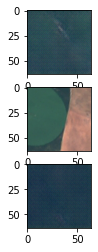

<Figure size 360x360 with 0 Axes>

In [25]:
n_show = 1
model.discriminator.eval()
model.encoder.eval()
model.generator.eval()

plt.figure(figsize=(4, 4))
f, axarr = plt.subplots(3,1)


with torch.no_grad():
    real = data.__getitem__(1)[0]
    real = real[None, :]
    #real = real.to(device)
    z = Variable(torch.randn((1, 100, 1, 1)), requires_grad=False)
    #z = z.to(device)
    gener = model.generator(z).cpu()
    z_hat = model.encoder(real)
    z_hat = z_hat

    recon = model.generator(z_hat).cpu()
    real = real.cpu()

    axarr[0].imshow(gener[0].permute(1, 2, 0))
    axarr[1].imshow(real[0].permute(1, 2, 0))
    axarr[2].imshow(recon[0].permute(1, 2, 0))

    plt.figure(figsize=(5,5))
    plt.show()

In [26]:
downstream_model = DownstreamNet(input_dim = 100, encoder = model.encoder)

In [27]:
downstream_model.to(device)

DownstreamNet(
  (encoder): Encoder(
    (enc): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

In [28]:
downstream_loss_criterion = nn.CrossEntropyLoss().to(device)

In [29]:
downstream_lr = 0.001
downstream_optim = torch.optim.Adam(downstream_model.parameters(), lr = downstream_lr)

In [30]:
# specify the training parameters
num_epochs = 20  # number of training epochs
train_epoch_losses = []
validation_epoch_losses = []


for epoch in range(num_epochs):
    downstream_model.train()
    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        downstream_optim.zero_grad()
        out = downstream_model(images)
        loss = downstream_loss_criterion(out, labels)
        loss.backward()
        downstream_optim.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)

    # Specify you are in evaluation mode
    downstream_model.eval()
    with torch.no_grad():
        validation_mini_batch_losses = []
        for (images, labels) in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = downstream_model(images)
            # the class with the highest energy is what we choose as prediction
            validation_epoch_loss = downstream_loss_criterion(outputs, labels)
            # collect mini-batch reconstruction loss
            validation_mini_batch_losses.append(loss.data.item())
        validation_epoch_loss = np.mean(validation_mini_batch_losses)
        validation_epoch_losses.append(validation_epoch_loss)

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print(
        f"[LOG {now}] epoch: {epoch+1} train-loss: {train_epoch_loss} validation-loss: {validation_epoch_loss}"
    )

100%|██████████| 31/31 [00:45<00:00,  1.47s/it]


[LOG 20221108-10:38:24] epoch: 1 train-loss: 1.519186100652141 validation-loss: 1.0366567373275757


100%|██████████| 31/31 [00:38<00:00,  1.25s/it]


[LOG 20221108-10:39:11] epoch: 2 train-loss: 0.8989384751166066 validation-loss: 0.8331553339958191


100%|██████████| 31/31 [00:38<00:00,  1.23s/it]


[LOG 20221108-10:39:58] epoch: 3 train-loss: 0.7221479185165898 validation-loss: 0.651337206363678


100%|██████████| 31/31 [00:38<00:00,  1.23s/it]


[LOG 20221108-10:40:44] epoch: 4 train-loss: 0.6283031240586312 validation-loss: 0.6479775905609131


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


[LOG 20221108-10:41:30] epoch: 5 train-loss: 0.6032253273071781 validation-loss: 0.5315765738487244


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


[LOG 20221108-10:42:16] epoch: 6 train-loss: 0.5423162983309838 validation-loss: 0.6405068635940552


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


[LOG 20221108-10:43:02] epoch: 7 train-loss: 0.5031148925904305 validation-loss: 0.4574432969093323


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


[LOG 20221108-10:43:48] epoch: 8 train-loss: 0.4826222398588734 validation-loss: 0.46587860584259033


100%|██████████| 31/31 [00:38<00:00,  1.23s/it]


[LOG 20221108-10:44:34] epoch: 9 train-loss: 0.43075431066174663 validation-loss: 0.44913071393966675


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


[LOG 20221108-10:45:20] epoch: 10 train-loss: 0.4016058416135849 validation-loss: 0.4399718642234802


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


[LOG 20221108-10:46:06] epoch: 11 train-loss: 0.3921018281290608 validation-loss: 0.47272175550460815


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


[LOG 20221108-10:46:52] epoch: 12 train-loss: 0.3638359240947231 validation-loss: 0.34459948539733887


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


[LOG 20221108-10:47:37] epoch: 13 train-loss: 0.35297184894161837 validation-loss: 0.39796698093414307


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


[LOG 20221108-10:48:23] epoch: 14 train-loss: 0.3307064098696555 validation-loss: 0.27322646975517273


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


[LOG 20221108-10:49:09] epoch: 15 train-loss: 0.29154255024848447 validation-loss: 0.28873980045318604


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


[LOG 20221108-10:49:55] epoch: 16 train-loss: 0.2663612380143135 validation-loss: 0.29056909680366516


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


[LOG 20221108-10:50:40] epoch: 17 train-loss: 0.26648313095492704 validation-loss: 0.26258546113967896


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


[LOG 20221108-10:51:26] epoch: 18 train-loss: 0.25592216368644466 validation-loss: 0.23822031915187836


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


[LOG 20221108-10:52:12] epoch: 19 train-loss: 0.24393703524143465 validation-loss: 0.19143237173557281


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


[LOG 20221108-10:52:58] epoch: 20 train-loss: 0.20512924799996038 validation-loss: 0.2570183575153351


## Model Evaluation

In [31]:
def visualize_losses_during_training(
    train_epoch_losses: List[float], validation_epoch_losses: List[float]
) -> None:
    """
    Visualizes losses gathered during training.
    :param train_epoch_losses: List containing training loss per epoch
    :param validation_epoch_losses: List containing validation loss per epoch
    :return: None
    """
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # add grid
    ax.grid(linestyle="dotted")

    # plot the training epochs vs. the epochs' classification error
    ax.plot(
        np.array(range(1, len(train_epoch_losses) + 1)),
        train_epoch_losses,
        label="epoch train. loss (blue)",
    )
    ax.plot(
        np.array(range(1, len(validation_epoch_losses) + 1)),
        validation_epoch_losses,
        label="epoch val. loss (blue)",
    )
    # add axis legends
    ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
    ax.set_ylabel("[Classification Error $\\mathcal{L}^{CE}$]", fontsize=10)

    # set plot legend
    plt.legend(loc="upper right", numpoints=1, fancybox=True)

    # add plot title
    plt.title("Training Epochs $e_i$ vs. Classification Error $L^{CE}$", fontsize=10)

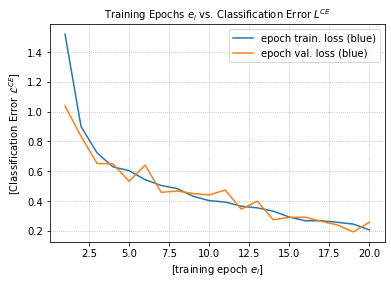

In [32]:
visualize_losses_during_training(train_epoch_losses, validation_epoch_losses)

In [33]:
y_pred = []
y_true = []
# iterate over test data
downstream_model.eval()
with torch.no_grad():
    for (images, labels) in tqdm(test_dataloader, desc="Predict labels"):
        images = images.to(device)

        outputs = downstream_model(images)  # Feed Network
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())  # Save Prediction
        y_true.extend(labels.numpy())  # Save Truth

Predict labels: 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.63      0.75       602
           1       0.85      0.89      0.87       586
           2       0.83      0.71      0.76       594
           3       0.79      0.63      0.70       515
           4       0.89      0.93      0.91       488
           5       0.71      0.67      0.69       418
           6       0.55      0.86      0.67       499
           7       0.84      0.99      0.91       596
           8       0.66      0.87      0.75       511
           9       0.98      0.67      0.80       591

    accuracy                           0.78      5400
   macro avg       0.80      0.78      0.78      5400
weighted avg       0.81      0.78      0.79      5400

